In [1]:
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt

The aim of this notebook is to use QuantLib to build a yield curve and test the impact of different piecewise interpolation methods.

In [2]:
# Define the market data
# Input convention: (Instrument, fwd start, tenor, rate)

yts = ql.RelinkableYieldTermStructureHandle()

# Input market observables here
# Using the SimpleQuote structure helps in bumping rates later by leveraging SimpleQuote methods
rates = {
    ('Deposit', None, '1M'): ql.SimpleQuote(0.01),
    ('Deposit', None, '2M'): ql.SimpleQuote(0.01),
    ('FRA', 3, 6): ql.SimpleQuote(0.0105),
    ('FRA', 6, 9): ql.SimpleQuote(0.011),
    ('FRA', 9, 12): ql.SimpleQuote(0.0115),
    ('FRA', 12, 15): ql.SimpleQuote(0.012),
    ('FRA', 15, 18): ql.SimpleQuote(0.012),
    ('FRA', 18, 21): ql.SimpleQuote(0.0125),
    ('FRA', 21, 24): ql.SimpleQuote(0.0125),
    ('Swap', '0D' , '2Y'): ql.SimpleQuote(0.0117),
    ('Swap', '0D' , '3Y'): ql.SimpleQuote(0.0117),
    ('Swap', '0D' , '4Y'): ql.SimpleQuote(0.0115),
    ('Swap', '0D' , '5Y'): ql.SimpleQuote(0.0115),
    ('Swap', '0D' , '7Y'): ql.SimpleQuote(0.0115),
    ('Swap', '0D' , '10Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '12Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '15Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '20Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '25Y'): ql.SimpleQuote(0.012),
    ('Swap', '0D' , '30Y'): ql.SimpleQuote(0.012)
}

# Helpers contain info about the instruments used to define the curve
rateHelper = ql.RateHelperVector()

# The conventions to use
index = ql.Euribor3M(yts)
calendar = ql.TARGET()
convention = ql.Following
dayCount = ql.Actual360()
fixingDays = 0
fixedFrequency=ql.Annual
fixedDayCount = ql.Thirty360()
 
# Loop through input rates and add to rateHelper
for v in rates.keys():
    inst, fwd_start, tenor = v
    rate = rates[v]
    
    # If it's a depo then use the DepositRateHelper class
    if inst == 'Deposit':
        rateHelper.append(ql.DepositRateHelper(ql.QuoteHandle(rate),
                                               ql.Period(tenor),
                                               fixingDays,
                                               calendar,
                                               convention,
                                               False,
                                               dayCount))
    
    # If a FRA then use the FraRateHelper method
    if inst == 'FRA':
        rateHelper.append(ql.FraRateHelper(ql.QuoteHandle(rate),
                                           fwd_start,
                                           tenor,
                                           fixingDays,
                                           calendar,
                                           convention,
                                           False,
                                           dayCount))
    
    # If a swap then use the SwapRateHelper method
    if inst == 'Swap':
        rateHelper.append(ql.SwapRateHelper(ql.QuoteHandle(rate),
                                            ql.Period(tenor),
                                            calendar,
                                            fixedFrequency,
                                            convention,
                                            fixedDayCount,
                                            index,
                                            ql.QuoteHandle(ql.SimpleQuote(0.0)),
                                            ql.Period(fwd_start)))

Next, we build a bunch of curves using the same market data inputs, but different interpolation assumptions.

In [3]:
# Build a bunch of curves using the same inputs but different interps
today = ql.Date(14,3,2021)

params = [today, rateHelper, dayCount]

curves = {
    "PiecewiseFlatForward": ql.PiecewiseFlatForward(*params),
    "LogLinearDiscount": ql.PiecewiseLogLinearDiscount(*params),
    "LogCubicDiscount": ql.PiecewiseLogCubicDiscount(*params),
    "LinearZero": ql.PiecewiseLinearZero(*params),
    "CubicZero": ql.PiecewiseCubicZero(*params),
    "LinearForward": ql.PiecewiseLinearForward(*params),
    "SplineCubicDiscount": ql.PiecewiseSplineCubicDiscount(*params)}

Some helper functions to easily build FRAs and swaps. To infer market rates later on and observe how they change when the inputs on the curve are changed, we basically need to build and value basic instruments.

In [4]:
# Helper functions
def quick_swap(fstart,mat,index,engine):
    return ql.MakeVanillaSwap(ql.Period(mat),index,0.00,ql.Period(fstart),
                              Nominal=1e6,pricingEngine=engine)

def quick_FRA(fstart,end,index,yts,today):
    return ql.ForwardRateAgreement(today+ql.Period(fstart),today+ql.Period(end),
                                   ql.Position.Long,0.00,1e6,index,yts)

We can also extract forward rates (from forward starting instruments) using different interpolation assumptions. See below how to extract and plot these.

<AxesSubplot:>

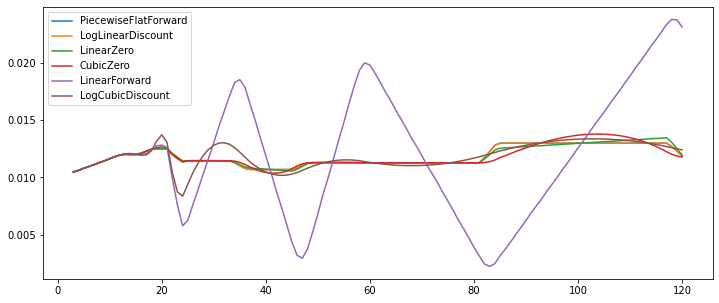

In [5]:
# Grab forward rates
fwds = [(str(i)+'M',str(i+1)+'M') for i in range(3,121)]
fwds_i = [i for i in range(3,121)]
out = {}

# A frame to record forwards
df_fwds = pd.DataFrame(index=fwds_i)

interp_methods = ['PiecewiseFlatForward','LogLinearDiscount','LinearZero','CubicZero','LinearForward','LogCubicDiscount']

for k in interp_methods:
    yts.linkTo(curves[k])

    # Generate the fair forwards
    for j in range(len(fwds)):
        out[fwds_i[j]] = quick_FRA(*fwds[j],index,yts,today).forwardRate().rate()
    
    # Add to df
    df_fwds[k] = list(out.values())

df_fwds.plot(figsize=(12,5))

Next, we define the instruments that we will use to observe the impact of perturbing the inputs of our curve.

Essentially:
- For each instrument used to build the curve, perturb the quote and rebuild the curve
- Reprice all instruments in our book i.e. in this case work out what the 'fair rate' for those is
- Compare those 'fair rates' with the initial rates from the base curve

We expect the following:
- The impact on instruments that are explicitly used to build the curve should be independent of the interpolation method
- Instruments that are not explicitly used in the build (i.e. are interp'ed) will depend on the interp method

In [6]:
swaps_on_curve = [['0D','2Y'],['0D','3Y'],['0D','4Y'],['0D','5Y'],['0D','7Y'],['0D','10Y'],
                  ['0D','12Y'],['0D','15Y'],['0D','20Y'],['0D','25Y'],['0D','30Y']]

swaps_off_curve = [['0D','2Y6M'],['0D','3Y6M'],['0D','4Y6M'],['0D','5Y6M'],['0D','7Y6M'],['0D','8Y'],
                  ['0D','8Y6M'],['0D','9Y'],['0D','9Y6M'],['0D','10Y6M'],['0D','11Y'],['0D','11Y6M'],
                   ['0D','12Y6M'],['0D','13Y'],['0D','13Y6M'],['0D','14Y'],['0D','14Y6M']]

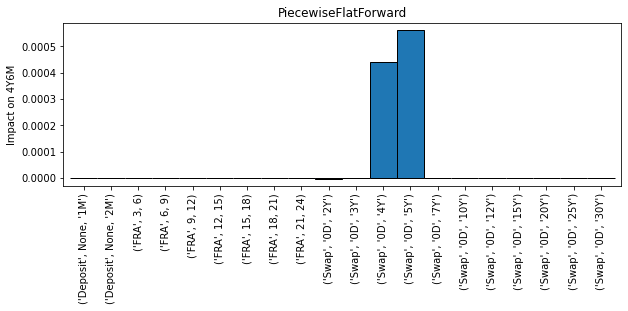

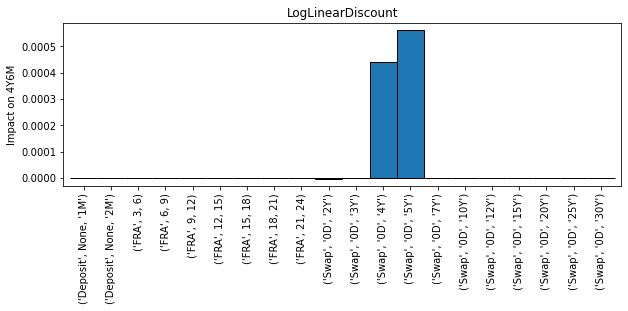

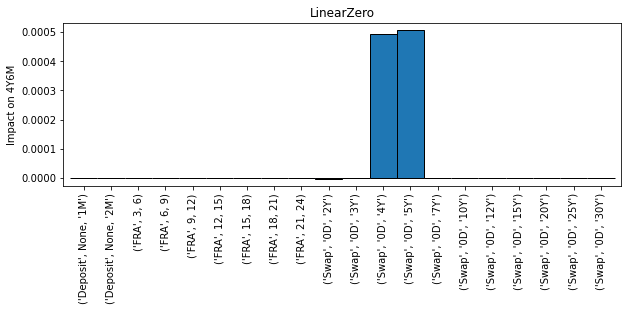

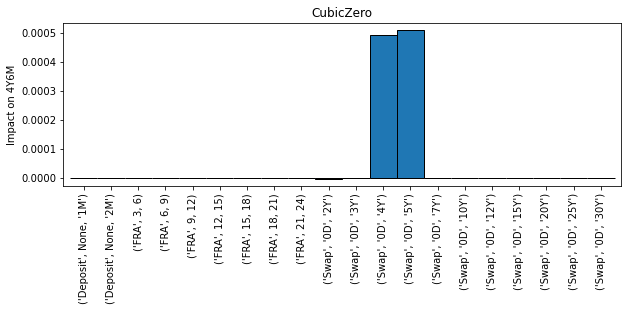

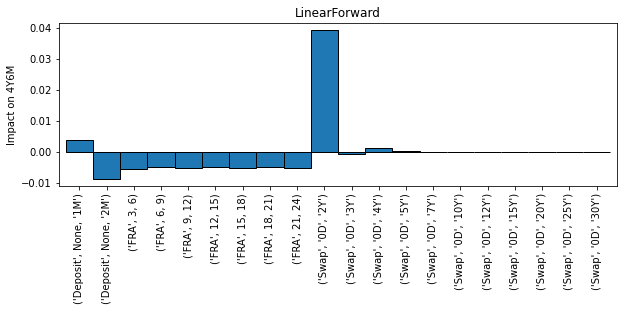

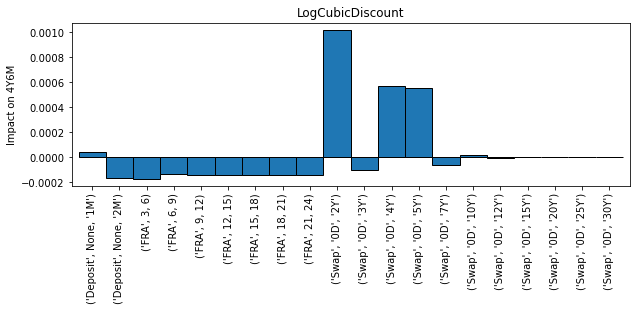

In [7]:
# Plot effect of interp method on tweak
for k in interp_methods:
    yts.linkTo(curves[k])
    engine = ql.DiscountingSwapEngine(yts)

    base_price = [quick_swap(*swap,index,engine).fairRate() for swap in swaps_off_curve]
    tweaked_prices = []

    for inst in rates.keys():    
        rates[inst].setValue(rates[inst].value() + 0.0005)
        tweaked_prices.append([quick_swap(*swap,index,engine).fairRate() for swap in swaps_off_curve])
        rates[inst].setValue(rates[inst].value() - 0.0005) 
        
    tmp = pd.DataFrame(tweaked_prices,columns=[i[1] for i in swaps_off_curve],index=[str(i) for i in rates.keys()])
    tmp = (tmp - base_price) *2
    
    tmp.loc[:,'4Y6M'].plot(rot=90,kind='bar',figsize=(10,3),width=1,edgecolor='black', title=k,ylabel= 'Impact on 4Y6M')
    
    plt.show()

So we can see that the 4.5Y rate will be influenced by tweaks to the building blocks of our curve. Ideally, we want the 4.5Y rate to be sensitive to only inputs that are very close to it e.g. the 4Y and 5Y points. This is important for risk management in the sense that we want to be able to accurately price and risk manage products in the 4.5Y area by observing and hedging using inputs that are directly relevant to that part of the curve (a 'local' measure).

Reference:

https://quantlib-python-docs.readthedocs.io/en/latest/termstructures.html#yield-term-structures